In [1]:
import numpy as np
import rdkit
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem, RDConfig, Geometry, RDLogger, DataStructs
from rdkit.Chem import AllChem, ChemicalFeatures, rdDistGeom, rdMolTransforms, rdShapeAlign, Draw, rdChemicalFeatures, rdMolAlign
from rdkit.Chem.Pharm3D import Pharmacophore, EmbedLib
from rdkit.Numerics import rdAlignment
from rdkit.Chem.Draw import IPythonConsole, MolDrawing
from rdkit.Chem.Draw.MolDrawing import DrawingOptions
from rdkit.Chem.FeatMaps import FeatMapUtils, FeatMaps
from rdkit.ML.Cluster import Butina
import os
import itertools
import copy
import random
import scipy
from scipy.spatial.transform import Rotation as R
import py3Dmol
import pickle
import sklearn as skl
import umap
DrawingOptions.includeAtomNumbers=True

when making test set, make sure to calculate Tanimoto scores to training set, report max scores and save plot

next step is to try on entire EGFR dataset (~1600 compounds) with train/test ratio of 0.8/0.2 or 0.7/0.3; knowing the minimum number of compounds required for useful results is helpful

try feed-forward neural network classifier as well

ues multiprocess for multi-threading (normally benefits cap at ~2 CPUs)

additional things that need to be saved:
- all the classifiers
- representative conformers (in addition to all conformers)
- reference molecule used for alignments

leave out ~100-200 molecules from training set for final validation

In [2]:
def optimal_kmeans(data,min_k=2,max_k=10,random_state=None):
    '''
    Determines optimal k for k-means clustering and performs clustering at optimal value
    Args:
    data: matrix of data to cluster
    min_k, max_k: min and max values of k to sweep over
    random_state: seed for randomization
    Returns:
    opt_clusts: cluster assignments for optimal value of k
    best_k: k value that maximizes silhouette score
    max_silhouette: silhouette score of optimal k
    silhouettes: list of silhouette scores for each k value attempted
    '''
    max_silhouette = -1
    silhouettes = []
    best_k=min_k
    # iterate over all ks and find maximum silhouette score
    for k in range(min_k,max_k):
        clusterer = skl.cluster.KMeans(n_clusters=k,random_state=random_state)
        clust_labels = clusterer.fit_predict(data)
        silhouette_avg = skl.metrics.silhouette_score(data,clust_labels)
        silhouettes.append(silhouette_avg)
        if silhouette_avg>max_silhouette:
            best_k = k
            max_silhouette = silhouette_avg
    # run optimal clustering
    opt_clusterer = skl.cluster.KMeans(n_clusters=best_k,random_state=random_state)
    opt_clusts = opt_clusterer.fit_predict(data)
    return opt_clusts, best_k, max_silhouette, silhouettes

def optimal_hierarchical_clustering(data,min_nclust,max_nclust):
    '''
    Determines optimal n for hierarchical clustering and performs clustering at optimal value
    Args:
    data: matrix of data to cluster
    min_nclust, max_nclust: min and max values of n to sweep over
    Returns:
    opt_clusts: cluster assignments for optimal value of n
    best_n: number of clusters that maximizes silhouette score
    max_silhouette: silhouette score of optimal n
    silhouettes: list of silhouette scores for each n value attempted
    '''
    max_silhouette = -1
    silhouettes = []
    best_n=min_nclust
    # iterate over all n and find maximum silhouette score
    for n in range(min_nclust,max_nclust):
        clusterer = skl.cluster.AgglomerativeClustering(n_clusters=n)
        clust_labels = clusterer.fit_predict(data)
        silhouette_avg = skl.metrics.silhouette_score(data,clust_labels)
        silhouettes.append(silhouette_avg)
        if silhouette_avg>max_silhouette:
            best_n = n
            max_silhouette = silhouette_avg
    # run optimal clustering
    opt_clusterer = skl.cluster.AgglomerativeClustering(n_clusters=best_n)
    opt_clusts = opt_clusterer.fit_predict(data)
    return opt_clusts, best_n, max_silhouette, silhouettes

def confs_from_smiles(smiles,num_embed=100,align=True,random_seed=-1):
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)
    confs = AllChem.EmbedMultipleConfs(mol,numConfs=num_embed,randomSeed=random_seed)
    optimize_res = AllChem.MMFFOptimizeMoleculeConfs(mol)
    AllChem.AlignMolConformers(mol)
    return mol

def generate_LE_conformers(mols,embed_count=100,random_seed=-1,save=False,filename=None):
    out_mols = []
    for mol in mols:
        confs = AllChem.EmbedMultipleConfs(mol,numConfs=embed_count,
                                            randomSeed=random_seed)
        res=AllChem.MMFFOptimizeMoleculeConfs(mol)
        LE_conf_ID = res.index(min(res,key=lambda t: t[1]))
        out_mol = Chem.Mol(mol,confId=LE_conf_ID)
        out_mols.append(out_mol)
    if save:
        if filename:
            save_file = filename
        else:
            save_file = "LE_conformers.pkl"
        with open(save_file,"wb") as file:
            pickle.dump(out_mols,file)
    return out_mols
                
def get_representative_conformers(mol,thresh=1.5,make_mols=False):
    '''
    Generate set of representative conformers from an input molecule
    Args:
    mol: molecule (with conformers already generated) to make conf set from
    thresh: distance threshold [Angstroms] beyond which conformers are not considered neighbors
    make_mols: whether or not to return new rdMol objects
    Returns:
    new_mols: list of rdMol objects with one conformer each if make_mols==True, or None if make_mols==False
    '''
    # align conformers and get RMSDs
    dist_matrix = AllChem.GetConformerRMSMatrix(mol)
    cids = [c.GetId() for c in mol.GetConformers()]
    # cluster conformers and extract centroids; cluster centroids are representative conformers
    clusts = Butina.ClusterData(dist_matrix,len(cids),distThresh=thresh,isDistData=True,reordering=True)
    centroids = [x[0] for x in clusts]
    centroid_cids = [cids[i] for i in centroids]
    if make_mols: # make new single-conformer rdMol objects if desired
        new_mols=[]
        for c in centroid_cids:
            nm = Chem.Mol(mol,confId=c)
            new_mols.append(nm)
    else:
        new_mols=None
    return clusts, centroid_cids, new_mols

def extract_features(mols,feature_factory=None):
    '''
    Extract pharmacophoric features from a set of molecules
    Args:
    mols: list of rdMol objects to get features from
    feature_factory: rdkit feature factory built from definitions of features of interest.
        will use rdkit default if None provided
    Returns:
    feat_df: pd.DataFrame containing feature families and x,y,z positions
    '''
    # get rdkit default feature factory if none was provided
    if feature_factory == None:
        feature_path = os.path.join(RDConfig.RDDataDir, 'BaseFeatures.fdef')
        feature_factory = ChemicalFeatures.BuildFeatureFactory(feature_path)
    families = []
    xs = []
    ys = []
    zs = []
    end_index=0
    # loop over molecules and extract ph4 features
    for m in mols:
        feats = feature_factory.GetFeaturesForMol(m)
        aromatic_positions = []
        for f in feats:
            families.append(f.GetFamily())
            xs.append(f.GetPos().x)
            ys.append(f.GetPos().y)
            zs.append(f.GetPos().z)
        # some kludge to get around rdkit's bad feature definitions
        # (removing lumped hydrophobes that overlap with aromatics)
            if f.GetFamily().lower()=='aromatic':
                aromatic_positions.append((f.GetPos().x,f.GetPos().y,f.GetPos().z))
        bad_indices = []
        for i in range(len(feats)):
            f = feats[i]
            if f.GetFamily().lower()=='lumpedhydrophobe':
                pos = (f.GetPos().x,f.GetPos().y,f.GetPos().z)
                if pos in aromatic_positions:
                    bad_indices.append(i)
        bad_indices = [x+end_index for x in bad_indices]
        for i in sorted(bad_indices,reverse=True):
            del families[i]
            del xs[i]
            del ys[i]
            del zs[i]
        end_index=len(families)
    # pack data into pd.DataFrame
    feat_df = pd.DataFrame({"Family":families,'x':xs,'y':ys,'z':zs})
    return feat_df

def align_conformers(mols,ref_mol=None):
    '''
    Canonicalize all conformers of input molecules and align them
    Args:
    mols: iterable of rdMol objects
    ref_mol: reference molecule to align to. will use first molecule if none provided
    Returns:
    RMSDs: list of RMSD values for optimal alignments. lower indicates better alignment
    scores: list of scores produced by O3A for optimal alignments. higher indicates better alignment
    '''
    if ref_mol==None:
        ref_mol = mols[0]
    # extract molecule properties for aligner
    ref_params = AllChem.MMFFGetMoleculeProperties(ref_mol)
    RMSDs = []
    scores = []
    # loop over query molecules to align
    for m in mols:
        # canonicalize conformers first to have consistent starting point
        rdMolTransforms.CanonicalizeMol(m)
        mmff_params=AllChem.MMFFGetMoleculeProperties(m)
        mol_scores={}
        mol_RMSDs = {}
        # get Aligner objects for each conformer
        aligners = rdMolAlign.GetO3AForProbeConfs(m,ref_mol,1,mmff_params,ref_params)
        # loop over conformers and run alignments
        for i in range(len(aligners)):
            rmsd = aligners[i].Align()
            conf = m.GetConformers()[i]
            cid=conf.GetId()
            conf_score = aligners[i].Score()
            mol_scores[cid]=conf_score
            mol_RMSDs[cid]=rmsd
        scores.append(mol_scores)
        RMSDs.append(mol_RMSDs)
    return RMSDs,scores

def cluster_features(feats,clust_method='hierarchical',max_n=10,random_state=None):
    '''
    Cluster pharmacophore features, either by hierarchical or k-means clustering
    Args:
    feats: pd.DataFrame of ph4 features to cluster. column names should include 'Family', 'x', 'y', 'z'
    clust_method: clustering method to use ('hierarchical' or 'k-means')
    max_n: maximum number of clusters to consider in screen
    random_state: seed for randomization, used for k-means clustering
    Returns:
    clustered_feats: pd.DataFrame of features with cluster IDs added
    clust_qc: tuple of (best_n,max_silhouette,silhouettes) returned by optimal clustering functions'''
    clustered_feats = []
    clust_qc = {}
    # only want to cluster feats within each feature type
    feats_by_fam = feats.groupby('Family')
    for fam, group in feats_by_fam:
        pos_matrix = group[['x','y','z']].to_numpy()
        # reduce max_n if there aren't enough features to cluster
        if max_n>np.shape(pos_matrix)[0]-1:
            max_n = np.shape(pos_matrix)[0]-1
        # run optimal clustering
        if clust_method == 'hierarchical':
            opt_clusts, best_n, max_silhouette, silhouettes = optimal_hierarchical_clustering(pos_matrix,
                                                                                              min_nclust=2,
                                                                                              max_nclust=max_n)
        elif clust_method=='k_means':
            opt_clusts,best_n,max_silhouette,silhouettes = optimal_kmeans(pos_matrix, min_k=2, max_k=max_n,
                                                                          random_state=random_state)
        # assign cluster IDs to features
        group['Cluster'] = opt_clusts
        if len(clustered_feats)==0:
            clustered_feats = [group]
        else:
            clustered_feats.append(group)
        # package QC information
        clust_qc[fam] = (best_n,max_silhouette,silhouettes)
    clustered_feats = pd.concat(clustered_feats).reset_index(drop=True)
    return clustered_feats, clust_qc

def compute_feature_centroid_sigma(feats):
    '''
    Compute centroid and Gaussian sigma for consensus feature clusters
    Args:
    feats: pd.DataFrame of ph4 features, with cluster IDs
    Returns:
    consensus_feats: pd.DataFrame of consensus features, with (x,y,z) position set to cluster centroids
        and Gaussian sigma reported'''
    consensus_feats = []
    # extract feature clusters by family
    feats_by_fam = feats.groupby('Family')
    default_radius = 1.08265 # default value used by PubChem3D
    ## see https://jcheminf.biomedcentral.com/articles/10.1186/1758-2946-3-13
    default_sigma = (np.pi*(3*np.sqrt(2)/(2*np.pi))**(2/3))*default_radius**(-2)
    # calculated as per https://onlinelibrary.wiley.com/doi/full/10.1002/jcc.21307
    for fam, group in feats_by_fam:
        clusts = group.groupby('Cluster')
        for clust, g in clusts:
            n_feats = len(g)
            # only do centroid and standard deviation calculation if cluster has more than one feature
            if n_feats > 1:
                pos_matrix = g[['x','y','z']].to_numpy()
                centroid = np.average(pos_matrix,axis=0)
                # calculate standard deviation from covariance matrix
                # treat each consensus feature as a sphere, so use average
                cov = np.cov(pos_matrix.T)
                gauss_sigma = np.average(np.diag(cov))
                sigma = np.sqrt(gauss_sigma**2+default_sigma**2) # add variance of a single "color atom"; value from PubChem3D
            else:
                centroid = g[['x','y','z']].to_numpy()[0]
                sigma = default_sigma # default value used by PubChem3D
                ## see https://jcheminf.biomedcentral.com/articles/10.1186/1758-2946-3-13
            consensus_clust = pd.DataFrame({'Family':[fam],'x':[centroid[0]],'y':[centroid[1]],
                                            'z':[centroid[2]],'sigma':[sigma],'n_feats':[n_feats]})
            consensus_feats.append(consensus_clust)
    consensus_feats = pd.concat(consensus_feats).reset_index(drop=True)
    return consensus_feats

def cluster_by_fingerprint(mols,fp_method='RDKit',all_confs=False,
                        clust_method='k_means',max_k=10,random_state=None):
    '''
    Cluster rdMol objects based on molecular fingerprints
    Args:
    mols: list of rdMol objects to be clustered
    fp_method: fingerprint generation method to use
    all_confs: if True, cluster each conformer of input molecules separately. only works if fp_method=='atom_pair'
    clust_method: clustering method to use ('k_means' only for now, 'hierarchical' should be supported eventually)
    max_k: maximum number of clusters to attempt
    random_state: seed for randomization
    Returns:
    clust_dict: dictionary with keys=cluster IDs and values=list of molecules in each cluster
    umap_fit: UMAP dimensionality reduction representation of input mols
    clusts: clusters returned by optimal clustering function
    largest_clust: ID of largest cluster
    clust_qc: QC metrics returned by optimal clustering function
    '''
    if fp_method == 'RDKit':
        fpgen = AllChem.GetRDKitFPGenerator()
    elif fp_method == 'atom_pair':
        fpgen = AllChem.GetAtomPairGenerator()
    elif fp_method == 'torsion':
        fpgen = AllChem.GetTopologicalTorsionGenerator()
    elif fp_method == 'morgan':
        fpgen = AllChem.GetMorganGenerator()
    else:
        print("Unsupported fingerprint generation method. Please use RDKit, atom_pair, torsion, or morgan")
        return None
    fps = [fpgen.GetFingerprint(m) for m in mols]
    fp_array = np.asarray(fps)
    
    # dimensionality reduction
    reducer = umap.UMAP(metric='jaccard',random_state=random_state)
    umap_fit = reducer.fit_transform(fp_array)
    
    # clustering
    if clust_method == 'k_means':
        clusts, best_k, min_silhouette, silhouettes = optimal_kmeans(umap_fit,max_k=max_k,
                                                                    random_state=random_state)
        clust_qc = (best_k,min_silhouette,silhouettes)
    
    # make dict of molecules by cluster
    clust_dict={}
    largest_size=0
    largest_clust = -1
    for c in list(set(clusts)):
        clust_mols = [mols[i] for i in range(len(mols)) if clusts[i]==c]
        clust_dict[int(c)] = clust_mols
        if len(clust_mols)>largest_size:
            largest_size=len(clust_mols)
            largest_clust = int(c)
    return clust_dict,umap_fit,clusts,largest_clust,clust_qc

def get_pharmacophore_alignment(query,ref,verbose=False):
    '''
    Align two pharmacophores using Kabsch algorithm
    Args:
    query: rdPharm3D object to be aligned
    ref: rdPharm3D object to align against
        ref should contain only essential ph4 features
    verbose: whether to print diagnostic messages
    Returns:
    opt_feat_ids: list of indices for features in query that best
        match ref
    opt_mat: transform matrix to rotate query to optimally align to ref
    opt_rssd: root sum squared distance between query and ref, after
        alignment
    results: pd.DataFrame with all feature combinations, transform
        matrices, and rssd values'''
    # extract features from rdPharm3D objects
    ref_feats = ref.getFeatures()
    ref_df = pd.DataFrame({'family':[f.GetFamily() for f in ref_feats],
                        'x':[list(f.GetPos())[0] for f in ref_feats],
                        'y':[list(f.GetPos())[1] for f in ref_feats],
                        'z':[list(f.GetPos())[2] for f in ref_feats]})
    query_feats = query.getFeatures()
    query_df = pd.DataFrame({'family':[f.GetFamily() for f in query_feats],
                        'x':[list(f.GetPos())[0] for f in query_feats],
                        'y':[list(f.GetPos())[1] for f in query_feats],
                        'z':[list(f.GetPos())[2] for f in query_feats]})
    
    # get possible combinations of query features that match reference
    match_found = [False]*len(ref_df)
    matches = [None]*len(ref_df)
    for i in range(len(ref_df)):
        fam = ref_df['family'].iloc[i]
        fmatch = list(query_df.index[query_df['family']==fam])
        if len(fmatch)>0:
            matches[i]=fmatch
            match_found[i]=True
    if sum(match_found)<len(ref_df) and verbose:
        print("Warning: Not all reference features have possible matches in query")
    # remove unmatched features from reference
    # (they won't be useful for upcoming calculations)
    ref_matched = ref_df.iloc[match_found]
    ref_pos = ref_matched[['x','y','z']].to_numpy()
    
    # center reference features (subtract centroid from position)
    ref_centroid = np.mean(ref_pos,axis=0)
#     ref_pos = ref_pos-ref_centroid
    
    # test all combinations of query feature matches
    summary_feats = []
    summary_mats = []
    summary_rssd = []
    matches = [m for m in matches if m is not None]
    for q in list(itertools.product(*matches)):
        # skip any combinations that double-count a feature
        if len(np.unique(q))<len(q):
            continue
        # get transform matrix; try both unchanged and reflected probe configurations
        pos = query_df[['x','y','z']].iloc[list(q)].to_numpy()
        centroid = np.mean(pos,axis=0)
        pos = pos-centroid+ref_centroid
        SSD, mat = rdAlignment.GetAlignmentTransform(ref_pos,pos)
        SSD_reflect, mat_reflect = rdAlignment.GetAlignmentTransform(ref_pos,pos,reflect=True)
        summary_feats.append(list(q))
        if SSD_reflect<SSD:
            summary_mats.append(mat_reflect)
            summary_rssd.append(SSD_reflect)
        else:
            summary_mats.append(mat)
            summary_rssd.append(SSD)
        # compute optimal rotation
#         rot, rssd = R.align_vectors(ref_pos,pos)
#         rmat = rot.as_matrix()
#         summary_feats.append(list(q))
#         summary_mats.append(rmat)
#         summary_rssd.append(rssd)
    results = pd.DataFrame({'Feature IDs':summary_feats,
                            'Transform Matrix':summary_mats,
                            'RSSD':summary_rssd})
    # get optimal feature combination and corresponding transform/rssd
    opt_id = results['RSSD'].idxmin()
    opt_feat_ids,opt_mat,opt_rssd = results.loc[opt_id].tolist()
    
    return opt_feat_ids,opt_mat,opt_rssd,results

class PharmMapper:
    ff_path = os.path.join(RDConfig.RDDataDir,'BaseFeatures.fdef')
    ff=ChemicalFeatures.BuildFeatureFactory(ff_path)
    hits=[]
    decoys=[]

    def __init__(self,train_mols,test_mols,feature_factory=None,potency_key='IC50'):
        self.train_mols=train_mols
        self.test_mols = test_mols
        if feature_factory:
            self.ff = feature_factory
        self.potkey = potency_key
        
    @classmethod
    def from_pickle(cls,filename):
        '''
        Reconstruct PharmMapper from a previously pickled PharmMapper
        Args:
        filename: name of pickle file containing PharmMapper information
        Returns:
        mapper: reconstructed PharmMapper
        '''
        with open(filename,'rb') as file:
            ph4_dict = pickle.load(file)
        mapper = cls(ph4_dict['train_mols'],ph4_dict['test_mols'],
                     feature_factory=ph4_dict['feature_factory'],
                     potency_key=ph4_dict['potkey'])
        if 'all_feats' in ph4_dict.keys():
            mapper.all_feats=ph4_dict['all_feats']
            mapper.consensus_hits=mapper.all_feats.loc[mapper.all_feats['Class']=='active']
            mapper.consensus_decoys=mapper.all_feats.loc[mapper.all_feats['Class']=='inactive']
        if 'scaffold' in ph4_dict.keys():
            mapper.scaffold=ph4_dict['scaffold']
        if 'classifier' in ph4_dict.keys():
            mapper.classifier=ph4_dict['classifier']
        return mapper
            
            
    
    def __unpack_conformers(self,rep_only=True,dist_thresh=1.5):
        '''
        Unpack rdMol objects with multiple conformers into new rdMol objects with one conformer each
        Args:
        rep_only: whether to return only representative conformers or all conformers
        dist_thresh: maximum neighbor distance for representative conformer clustering
        Returns:
        new_mols: list of rdMol objects with one conformer each
        '''
        new_train_mols=[]
        new_test_mols=[]
        for m in self.train_mols:
            if len(m.GetConformers())>1:
                if rep_only:
                    # extract representative conformers if desired
                    _,_,mols_to_use = get_representative_conformers(m,thresh=dist_thresh,
                                                                    make_mols=True)
                    new_train_mols = new_train_mols + mols_to_use
                else:
                    # unpack all conformers into new rdMol objects
                    for c in m.GetConformers():
                        nm=Chem.Mol(m,confId=c.GetId())
                        new_train_mols.append(nm)
            else:
                # skip unpacking if molecule already has single conformer
                new_train_mols.append(m)
        for m in self.test_mols:
            if len(m.GetConformers())>1:
                if rep_only:
                    # extract representative conformers if desired
                    _,_,mols_to_use = get_representative_conformers(m,thresh=dist_thresh,
                                                                    make_mols=True)
                    new_test_mols = new_train_mols + mols_to_use
                else:
                    # unpack all conformers into new rdMol objects
                    for c in m.GetConformers():
                        nm=Chem.Mol(m,confId=c.GetId())
                        new_test_mols.append(nm)
            else:
                # skip unpacking if molecule already has single conformer
                new_test_mols.append(m)
        return new_train_mols,new_test_mols

    def __split_actives_inactives(self,thresh=0.1):
        '''
        Split training molecules into actives and inactives based on user-set potency threshold
        Args:
        thresh: cutoff value for potency metric (values less than thresh are active, greater are inactive)
        Returns: none'''
        for m in self.train_mols:
            if m.GetDoubleProp(self.potkey)<=thresh:
                self.hits.append(m)
            else:
                self.decoys.append(m)

    def prepare_mols(self,unpack=True,dist_thresh=1.5,potency_thresh=0.1,rep_only=True):
        '''
        Unpack and align molecules to prepare them for consensus feature identification
        Args:
        dist_thresh: maximum neighbor distance for representative conformer clustering
        potency_thresh: cutoff value for potency metric (values less than thresh are active, greater are inactive)
        rep_only: whether to return only representative conformers or all conformers
        Returns: none
        '''
        if unpack:
            self.train_mols,self.test_mols = self.__unpack_conformers(rep_only=rep_only,dist_thresh=dist_thresh)
        RMSDs,scores = align_conformers(self.train_mols)
        self.__split_actives_inactives(thresh=potency_thresh)
        self.scaffold = self.train_mols[0]


    def generate_training_features(self,clust_method='hierarchical',max_n_hits=10,
                                   max_n_decoys=30,random_state=None):
        '''
        Extract consensus ph4 features from identified hits and decoys
        Args:
        clust_method: clustering method to use ('hierarchical' or 'k_means')
        max_n_hits: maximum number of clusters to attempt when clustering features from hits
        max_n_decoys: maximum number of clusters to attempt when clustering features from decoys
        random_state: seed for randomization
        Returns: none
        '''
        allhits = extract_features(self.hits,self.ff)
        alldecoys = extract_features(self.decoys,self.ff)
        hit_clusts,_ = cluster_features(allhits,clust_method=clust_method,
                                        max_n=max_n_hits,random_state=random_state)
        self.consensus_hits = compute_feature_centroid_sigma(hit_clusts)
        self.consensus_hits['Class']=['active']*len(self.consensus_hits)
        decoy_clusts,_ = cluster_features(alldecoys,clust_method=clust_method,
                                          max_n=max_n_decoys,random_state=random_state)
        self.consensus_decoys = compute_feature_centroid_sigma(decoy_clusts)
        self.consensus_decoys['Class']=['inactive']*len(self.consensus_decoys)

    def __find_structural_features(self,sim_cutoff):
        '''
        Identify features of high similarity between active and inactive feature sets
        Args:
        sim_cutoff: similarity cutoff above which two features will be considered matched
        Returns: none
        '''
        # initialize distance and similarity matrices
        dists = np.full((len(self.consensus_hits),len(self.consensus_decoys)),np.inf)
        similarities = np.zeros((len(self.consensus_hits),len(self.consensus_decoys)))
        # loop over all feature pairs
        for i in range(len(self.consensus_hits)):
            for j in range(len(self.consensus_decoys)):
                # only consider pairs of same feature type
                if self.consensus_decoys['Family'].iloc[j]==self.consensus_hits['Family'].iloc[i]:
                    # extract feature positions and sigmas
                    pos1 = self.consensus_hits[['x','y','z']].iloc[i].to_numpy()
                    pos2 = self.consensus_decoys[['x','y','z']].iloc[j].to_numpy()
                    sig1 = self.consensus_hits['sigma'].iloc[i]
                    sig2 = self.consensus_decoys['sigma'].iloc[j]
                    # calculate Euclidean distance between centroids
                    dist = np.linalg.norm(pos2-pos1)
                    # calculate Tanimoto similarity of Gaussian volumes
                    overlap = 2*2.7*(np.pi/(sig1+sig2))**(3/2)*np.exp(-sig1*sig2*dist**2/(sig1+sig2))
                    self_overlap1 = 2*2.7*(np.pi/(sig1+sig1))**(3/2)
                    self_overlap2 = 2*2.7*(np.pi/(sig2+sig2))**(3/2)
                    sim = overlap/(self_overlap1+self_overlap2-overlap)
                    # record values
                    similarities[i,j]=sim
                    dists[i,j]=dist
        # find maximum similarity scores for each active feature
        max_sim_indices_1 = np.argmax(similarities,axis=1)
        # mark feature as matched if maximum score is above cutoff
        matched1 = [True if similarities[i,max_sim_indices_1[i]]>sim_cutoff else False 
                    for i in range(len(self.consensus_hits))]
        # record ID of matching feature if applicable
        match_indices_1 = [int(max_sim_indices_1[i]) if matched1[i]==True else None 
                           for i in range(len(self.consensus_hits))]
        # save info to hits DataFrame
        self.consensus_hits['Matched']=matched1
        self.consensus_hits['Match Partner']=match_indices_1
        self.consensus_hits['Maximum Similarity']=np.max(similarities,axis=1).tolist()
        # repeat the above process for decoys
        max_sim_indices_2 = np.argmax(similarities,axis=0)
        matched2 = [True if similarities[max_sim_indices_2[j],j]>sim_cutoff else False 
                    for j in range(len(self.consensus_decoys))]
        match_indices_2 = [int(max_sim_indices_2[j]) if matched2[j]==True else None 
                           for j in range(len(self.consensus_decoys))]
        self.consensus_decoys['Matched']=matched2
        self.consensus_decoys['Match Partner']=match_indices_2
        self.consensus_decoys['Maximum Similarity']=np.max(similarities,axis=0).tolist()

    def __assign_scoring_weights(self):
        '''Assign scoring weights to consensus features
            (defaults to number of component features for each consensus feature)
        Args: none
        Returns: none
        '''
        for f in [self.consensus_hits,self.consensus_decoys]:
            # if feature was matched between actives and inactives, set weight to 1 (minimum)
            # else, set weight to number of contributing features
            # more common features within a dataset should count more
            weights=[1 if f['Matched'].iloc[i]==True else f['n_feats'].iloc[i]
                     for i in range(len(f))]
            f['Weight'] = weights
            
    def calculate_score_matrix(self,mols,default_radius=1.08265,ref_key='all'):
        '''
        Calculate matrix of volumetric overlaps between a set of molecules and reference pharmacophore
        Args:
        mols: query molecules to calculate scores for
        default_radius: radius assigned to "color atoms" - i.e. if the centroid of a pharmacophore feature was
            represented by an atom, it would have this van der Waals radius
        ref_key: which reference features to use to calculate scores ('all', 'active', or 'inactive')
        Returns:
        score_mat: np.array of shape (len(mols),len(features)) containing volumetric overlap scores of each
            query molecule with each reference feature. scores are calculated by Tversky similarity with alpha=1
            (score = v_overlap/v_feature)
        '''
        # get the desired reference features from the consensus map(s)
        if ref_key=='all':
            ref_feats=self.all_feats
        elif ref_key=='active':
            ref_feats=self.consensus_hits
        elif ref_key=='inactive':
            ref_feats=self.consensus_decoys
        # initialize score matrix
        score_mat = np.zeros((len(mols),len(ref_feats)))
        # calculate standard deviation of color atoms
        default_sigma = (np.pi*(3*np.sqrt(2)/(2*np.pi))**(2/3))*default_radius**(-2)
        # helper sub-function to calculate volume overlaps between features of the same type
        def calc_overlaps(row):
            if type(row['Query Positions'])!=bool:
                dists = scipy.spatial.distance.cdist(row[['x','y','z']].to_numpy().reshape(-1,3).astype(float),
                                                     row['Query Positions'])
                overlap = np.sum(2*2.7*(np.pi/(row['sigma']+default_sigma))**(3/2)*
                                np.exp((-default_sigma*row['sigma']*dists**2)/
                                (default_sigma+row['sigma'])))
            else:
                overlap = 0
            return overlap
        # loop over query molecules and calculate overlap scores
        for i in range(len(mols)):
            # extract query features and group by feature type
            feats = extract_features([mols[i]])
            feats_by_group = feats.groupby('Family')
            # get positions of query features that match type of each reference feature
            ref_feats['Query Positions'] = [feats_by_group.get_group(f)[['x','y','z']].to_numpy()
                                            if f in feats_by_group.groups else False
                                            for f in ref_feats['Family']]
            # calculate Gaussian volume overlaps
            ref_feats['Overlaps'] = ref_feats.apply(calc_overlaps,axis=1)
            # calculate Tversky scores of overlaps, using reference feature volume as denominator
            score_mat[i,:] = ref_feats['Overlaps']/(2*2.7*(np.pi/(ref_feats['sigma']*2))**(3/2))
        # clean up reference feature dataframe
        ref_feats.drop('Query Positions',axis=1,inplace=True)
        ref_feats.drop('Overlaps',axis=1,inplace=True)
        return score_mat

    def make_consensus_ph4(self,unpack=True,dist_thresh=1.5,potency_thresh=0.1,rep_only=True,
              method='hierarchical',max_n_hits=10,max_n_decoys=30,
              sim_cutoff=0.75,random_state=None):
        '''
        Perform consensus feature identification pipeline
        Args:
        dist_thresh: maximum neighbor distance for representative conformer clustering
        potency_thresh: cutoff value for potency metric (values less than thresh are active, greater are inactive)
        rep_only: whether to return only representative conformers or all conformers
        method: clustering method to use ('hierarchical' or 'k_means')
        max_n_hits: maximum number of clusters to attempt when clustering features from hits
        max_n_decoys: maximum number of clusters to attempt when clustering features from decoys
        sim_cutoff: similarity cutoff above which two features will be considered matched
        random_state: seed for randomization
        Returns: none
        '''
        self.prepare_mols(unpack=unpack,dist_thresh=dist_thresh,potency_thresh=potency_thresh,
                                  rep_only=rep_only)
        self.generate_training_features(clust_method=method,max_n_hits=max_n_hits,
                                        max_n_decoys=max_n_decoys,random_state=random_state)
        self.__find_structural_features(sim_cutoff=sim_cutoff)
        self.__assign_scoring_weights()
        self.all_feats = pd.concat([self.consensus_hits,self.consensus_decoys])
        
    def make_classifier(self):
        '''
        Find the best-performing classifier from a variety of algorithms, and return that fitted classifier
        Args:none
        Returns:
        self.classifier: fitted classifier
        roc: mean ROC-AUC of best-performing classifier, from cross-validation
        results: list of dicts containing cross-validation results, potentially useful for downstream plotting
        '''
        self.training_scores = self.calculate_score_matrix(self.hits+self.decoys)
        self.training_labels = [1]*len(self.hits)+[0]*len(self.decoys)
        # scale scores, since Tversky scores can be >1
        scaler = skl.preprocessing.StandardScaler()
        scaled_scores = scaler.fit_transform(self.training_scores)
        # make Trainer, run cross-validation on range of classifiers and get best one
        self.trainer = Trainer(scaled_scores,self.training_labels)
        self.classifier,roc,results = self.trainer.find_best_classifier()
        # fit the best classifier on all the scaled training scores
        self.classifier.fit(scaled_scores,self.training_labels)
        return self.classifier,roc,results
    
    def predict(self):
        '''
        Use a fitted classifier to predict active/inactive probabilities for test set molecules
        Args: none
        Returns:
        self.test_probs: array of shape (len(test_mols),2) containing class probabilities for each test compound
        '''
        # calculate volumetric overlap scores
        self.test_overlaps = self.calculate_score_matrix(self.test_mols)
        # scale scores, since Tversky scores can be >1
        scaler = skl.preprocessing.StandardScaler()
        scaled_scores = scaler.fit_transform(self.test_overlaps)
        # predict class probabilities using pre-trained classifier
        self.test_probs = self.classifier.predict_proba(scaled_scores)
        return self.test_probs
         
    def __make_fps(self):
        '''
        Make molecular fingerprints of all compounds
        '''
        fpgen = AllChem.GetRDKitFPGenerator()
        self.train_fps = [fpgen.GetFingerprint(x) for x in self.train_mols]
        self.test_fps = [fpgen.GetFingerprint(x) for x in self.test_mols]

    
    def calculate_train_test_similarity(self,plot=False,plotfile=None):
        '''
        Calculate maximum Tanimoto similarity between test molecules and training set
        Args:
        plot: whether to plot maximum similarities and save the plot
        plotfile: filename to save plot to; only used if plot=True
        Returns:
        max_scores: list of maximum Tanimoto similarities between each test compound and the training set
        '''
        if not self.train_fps:
            self.__make_fps()
        self.train_test_sim = np.zeros(len(self.test_fps))
        for i in range(len(self.test_fps)):
            tanimotos = [DataStructs.TanimotoSimilarity(self.test_fps[i], f) for f in self.train_fps]
            max_sim = np.max(tanimotos)
            self.train_test_sim[i] = max_sim
        if plot:
            fig,ax = plt.subplots(1,1)
            ax.hist(self.train_test_sim)
            ax.set_xlabel('Maximum Tanimoto similarity')
            ax.set_ylabel('Counts')
            plt.savefig(plotfile,dpi=300)
        return self.train_test_sim


    def save(self,filename):
        '''
        Save mapper information to pickle for later reuse
        Args:
        filename: str name of file to save to
        Returns: none
        '''
        ph4_dict = {}
        if self.scaffold:
            ph4_dict['scaffold']=self.scaffold
        if self.all_feats:
            ph4_dict['all_feats']=self.all_feats
        if self.classifier:
            ph4_dict['classifier']=self.classifier
        if self.hits:
            ph4_dict['hits']=self.hits
            ph4_dict['decoys']=self.decoys
        ph4_dict['ff']=self.feature_factory
        ph4_dict['potkey']=self.potkey
        ph4_dict['train_mols']=self.train_mols
        ph4_dict['test_mols']=self.test_mols
        with open(filename,'wb') as file:
            pickle.dump(ph4_dict,file)
        
    def save_training_feats(self,filepath):
        # save consensus features to pickle for later use
        with open(filepath,'wb') as file:
            pickle.dump(self.all_feats,file)

    def read_ph4(self,ph4_file):
        # load consensus features from pickle and split into actives and inactives
        with open(ph4_file,'rb') as file:
            self.all_feats = pickle.load(file)
        self.consensus_hits=self.all_feats.loc[self.all_feats['Class']=='active']
        self.consensus_decoys=self.all_feats.loc[self.all_feats['Class']=='inactive']
        
class Trainer:
    '''
    Class to handle classifier model selection and training
    '''
    def __init__(self,train_data,train_labels):
        self.X = train_data
        self.y = train_labels
        
    def find_best_classifier(self):
        '''
        Try a range of classifier models and select the one with best ROC-AUC, using default parameters
        Args: none
        Returns:
        best_classifier: unfitted classifier model of type that hda best cross-validation performance
        self.roc_aucs[best_i]: mean ROC-AUC of best performing model in cross-validation
        classifier_opt_results: list of dicts containing cross-validation outputs, potentially useful for downstream analysis
        '''
        self.svm = skl.svm.SVC(probability=True)
        self.sgd = skl.linear_model.SGDClassifier(loss='modified_huber')
        self.k_neighbors = skl.neighbors.KNeighborsClassifier()
        self.hgbc = skl.ensemble.HistGradientBoostingClassifier()
        self.kernel_approx = skl.kernel_approximation.Nystroem()
        self.kernel_sgd = skl.linear_model.SGDClassifier(loss='modified_huber')
        self.classifiers = [self.svm,self.sgd,self.k_neighbors,self.hgbc]
        self.classifier_opt_results = []
        self.roc_aucs = []
        for c in self.classifiers:
            results = skl.model_selection.cross_validate(c,self.X,self.y,scoring='roc_auc',
                                                         return_estimator=True,return_indices=True)
            r_array = results['test_score']
            r = np.mean(r_array)
            self.roc_aucs.append(r)
            self.classifier_opt_results.append(results)
        self.classifiers.append(self.kernel_sgd)
        results_kernel = skl.model_selection.cross_validate(self.kernel_sgd,self.X,self.y,scoring='roc_auc',
                                                           return_estimator=True,return_indices=True)
        self.roc_aucs.append(np.mean(results_kernel['test_score']))
        self.classifier_opt_results.append(results_kernel)
        best_i = np.argmax(self.roc_aucs)
        best_classifier = self.classifiers[best_i]
        self.model = best_classifier
        return best_classifier,self.roc_aucs[best_i],self.classifier_opt_results  
    
    def parameter_sweep(self,classifier,param_grid):
        '''
        Perform cross-validated parameter sweep on a classifier to optimize hyperparameters
        '''
        pass
    

In [3]:
EGFR_ligands = pd.read_csv("EGFR_actives_nM_combined.ism",header=None,usecols=[0,1,4],
                           names=['Smiles','ID','Potency [nM]'],sep=' ')
EGFR_hits = EGFR_ligands.loc[EGFR_ligands['Potency [nM]']<=0.1]
EGFR_decoys = EGFR_ligands.loc[EGFR_ligands['Potency [nM]']>0.1].sample(frac=0.05,random_state=20251007)
with open("EGFR_decoys_multiple_confs.pkl",'rb') as file:
    decoys_multiple_confs = pickle.load(file)
for i in range(len(decoys_multiple_confs)):
    decoys_multiple_confs[i].SetDoubleProp('IC50',float(EGFR_decoys['Potency [nM]'].iloc[i]))
with open('EGFR_hits_multiple_confs.pkl','rb') as file:
    hits_multiple_confs = pickle.load(file)
for i in range(len(hits_multiple_confs)):
    hits_multiple_confs[i].SetDoubleProp('IC50',float(EGFR_hits['Potency [nM]'].iloc[i]))
training_set = decoys_multiple_confs+hits_multiple_confs

In [20]:
len(EGFR_ligands.loc[EGFR_ligands['Potency [nM]']<=5])

367

(array([  7.,   2.,  14.,  50., 146., 165., 238., 300., 345., 353.]),
 array([-5.80914299, -4.53947343, -3.26980388, -2.00013432, -0.73046477,
         0.53920479,  1.80887435,  3.0785439 ,  4.34821346,  5.61788302,
         6.88755257]),
 <BarContainer object of 10 artists>)

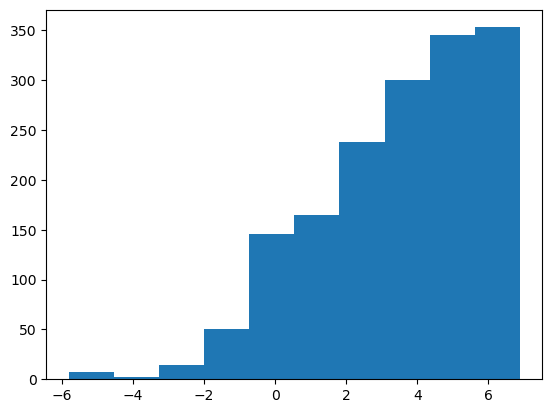

In [19]:
plt.hist(np.log(EGFR_ligands['Potency [nM]']))

In [16]:
len(EGFR_ligands)

1620

In [34]:
EGFR_decoys

,Smiles,ID,Potency [nM]
1582,CC(=O)N1CCC(CC1)Oc2cc(cc3c2c(ncn3)Nc4ccc(c(c4)...,342114,873.0
1526,Cn1c2ccccc2c3c1ncnc3Nc4cccc(c4)Br,252531,742.0
1491,c1cc(cc(c1)Br)Nc2c3ccc(nc3ncn2)F,82054,684.0
652,c1cc(cc(c1)O)c2c3c(ncnc3Nc4cccc(c4)Cl)n[nH]2,197606,26.0
1159,c1ccnc(c1)Oc2ccc(cc2Cl)Nc3c4c(cc(s4)C#C[C@@H]5...,457149,190.0
...,...,...,...
1198,CN(c1ccc2c(c1)c(ncn2)Nc3cccc(c3)Cl)C(=O)N(CCCl...,349666,204.0
504,CCOc1cc2c(cc1OCC)ncnc2Nc3cccc(c3)c4cncs4,208967,11.0
1109,c1ccc2c(c1)c3c([nH]2)nc(nc3Nc4cccc(c4)Br)N,252044,147.0
355,c1cc(cc(c1)Cl)Nc2c3c([nH]nc3ncn2)Nc4ccc(cc4)N,197234,5.0


In [22]:
type(EGFR_decoys['ID'].iloc[0])

numpy.int64

In [4]:
test2 = PharmMapper(training_set)
test2.read_ph4_pickle('EGFR_subset_ph4_feats.pkl')
test2.prepare_training_set()

In [5]:
model,best_roc,rocs = test2.make_classifier()

In [6]:
best_roc

np.float64(0.9055819364189407)

In [7]:
model

,loss,'log_loss'
,learning_rate,0.1
,max_iter,100
,max_leaf_nodes,31
,max_depth,None
,min_samples_leaf,20
,l2_regularization,0.0
,max_features,1.0
,max_bins,255
,categorical_features,'from_dtype'
,monotonic_cst,None


In [11]:
rocs[3]['test_score']

array([0.91389668, 0.93266205, 0.97440738, 0.81361443, 0.89332914])

In [12]:
[r['test_score'] for r in rocs]

[array([0.58740489, 0.77323264, 0.84266834, 0.76179987, 0.5960772 ]),
 array([0.67070485, 0.88105727, 0.84466121, 0.74659115, 0.69477659]),
 array([0.53799559, 0.72529893, 0.88247325, 0.76316342, 0.49937067]),
 array([0.91389668, 0.93266205, 0.97440738, 0.81361443, 0.89332914]),
 array([0.70514618, 0.86165303, 0.86322635, 0.76746381, 0.63971051])]

In [13]:
len(test2.training_mols)

2376

In [15]:
print(len(test2.hits),len(test2.decoys))

106 2270


In [4]:
test = PharmMapper(training_set)

In [5]:
test.train(dist_thresh=2,max_n_hits=10,max_n_decoys=30,method='hierarchical',random_state=20251016)

In [33]:
test.consensus_decoys

,Family,x,y,z,sigma,n_feats,Class,Matched,Match Partner,Maximum Similarity,Weight
0,Acceptor,-9.491888,-2.243497,2.413092,6.528601,62,inactive,False,NaN,9.916471e-50,62
1,Acceptor,4.581386,2.751983,-4.049266,3.904603,64,inactive,False,NaN,3.805278e-12,64
2,Acceptor,3.057862,4.835427,0.217688,2.175637,398,inactive,False,NaN,4.144697e-02,398
3,Acceptor,-8.658602,-7.591420,-0.354124,3.353345,71,inactive,False,NaN,2.773937e-44,71
4,Acceptor,5.667648,8.556789,1.465315,3.695837,87,inactive,False,NaN,5.421301e-18,87
...,...,...,...,...,...,...,...,...,...,...,...
90,LumpedHydrophobe,-0.947205,-3.336678,-5.141123,2.071297,2,inactive,False,NaN,0.000000e+00,2
91,LumpedHydrophobe,-1.315886,-4.603904,3.229010,2.063987,2,inactive,False,NaN,0.000000e+00,2
92,LumpedHydrophobe,3.804088,1.469220,-0.297655,2.062899,1,inactive,False,NaN,0.000000e+00,1
93,PosIonizable,0.869697,-2.261572,-0.438777,11.629452,262,inactive,False,NaN,7.170281e-17,262


(array([181.,   5.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   2.]),
 array([1.0000e+00, 6.2750e+02, 1.2540e+03, 1.8805e+03, 2.5070e+03,
        3.1335e+03, 3.7600e+03, 4.3865e+03, 5.0130e+03, 5.6395e+03,
        6.2660e+03]),
 <BarContainer object of 10 artists>)

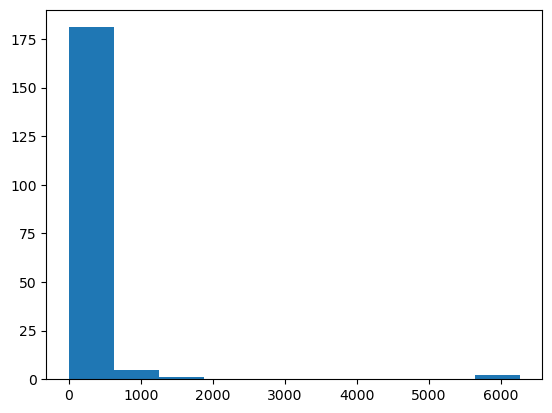

In [12]:
plt.hist(test.all_feats['n_feats'])

In [13]:
test.all_feats.loc[test.all_feats['n_feats']>3000]

,Family,x,y,z,sigma,n_feats,Class,Matched,Match Partner,Maximum Similarity,Weight
87,Hydrophobe,1.352110,4.271733,-0.123375,11.660642,5671,inactive,False,NaN,0.039155,5671
88,Hydrophobe,-3.508134,-2.981626,-0.341464,6.369435,6266,inactive,False,NaN,0.085139,6266


(array([58., 13.,  4.,  6.,  0.,  0.,  2.,  1.,  6.,  4.]),
 array([ 1. ,  5.3,  9.6, 13.9, 18.2, 22.5, 26.8, 31.1, 35.4, 39.7, 44. ]),
 <BarContainer object of 10 artists>)

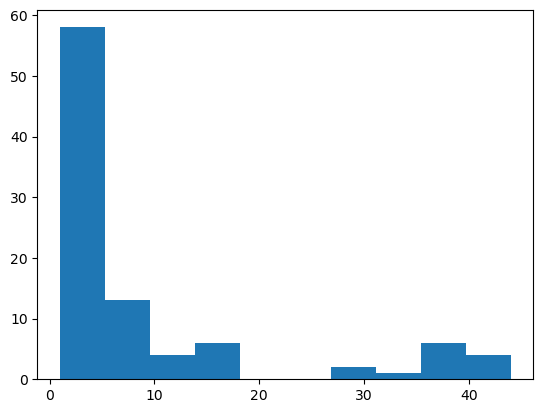

In [27]:
plt.hist(test.all_feats['n_feats'].loc[test.all_feats['Class']=='active'])

In [70]:
test.all_feats.loc[test.all_feats['Matched']==True]

,Family,x,y,z,sigma,n_feats,Class,Matched,Match Partner,Maximum Similarity,Weight
3,Acceptor,-2.712648,2.078406,-0.076984,2.075971,39,active,True,24.0,0.928171,1
6,Acceptor,-1.521092,4.263366,0.078338,2.062902,40,active,True,6.0,0.887334,1
11,Aromatic,-1.460401,2.720645,-0.100084,2.072936,47,active,True,38.0,0.890704,1
20,Donor,-1.558099,0.188267,-0.314437,2.063391,39,active,True,59.0,0.965911,1
21,Donor,3.389634,1.688103,0.091140,2.063082,18,active,True,75.0,0.814752,1
6,Acceptor,-1.285449,4.296003,0.131796,2.077052,826,inactive,True,6.0,0.887334,1
24,Acceptor,-2.714329,2.269152,-0.060423,2.064693,696,inactive,True,3.0,0.928171,1
38,Aromatic,-1.573048,2.922738,-0.036630,2.064705,725,inactive,True,11.0,0.890704,1
59,Donor,-1.680617,0.206729,-0.274721,2.068969,696,inactive,True,20.0,0.965911,1
75,Donor,3.562001,1.481503,-0.085841,2.087201,151,inactive,True,21.0,0.814752,1


In [7]:
test.pickle_training_feats('EGFR_subset_ph4_feats.pkl')

In [11]:
test2 = PharmMapper(training_set)
test2.read_ph4_pickle('EGFR_subset_ph4_feats.pkl')

In [72]:
test2.all_feats.loc[test2.all_feats['Family']=='Aromatic']

,Family,x,y,z,sigma,n_feats,Class,Matched,Match Partner,Maximum Similarity,Weight
9,Aromatic,1.289671,3.178336,0.028501,1.160836,49,active,False,NaN,7.435782e-01,49
10,Aromatic,-3.336658,-1.876050,0.013299,1.375723,31,active,False,NaN,7.100886e-01,31
11,Aromatic,-1.460401,2.720645,-0.100084,1.101654,47,active,True,38.0,9.397134e-01,1
12,Aromatic,-3.390450,-4.074067,-7.058704,2.090192,3,active,False,NaN,5.243955e-03,3
13,Aromatic,-2.910367,8.270757,-3.020902,4.391978,4,active,False,NaN,3.820284e-08,4
14,Aromatic,-1.078916,-1.970861,-2.590382,1.535303,8,active,False,NaN,4.152444e-01,8
15,Aromatic,-3.527241,-5.339535,4.579807,3.967175,3,active,False,NaN,7.619324e-04,3
16,Aromatic,7.659916,6.215860,-5.670818,1.082650,1,active,False,NaN,2.017341e-10,1
17,Aromatic,7.984189,4.817829,5.693748,1.082650,1,active,False,NaN,1.783240e-03,1
29,Aromatic,-0.050887,0.825609,-0.223607,1.302587,170,inactive,False,NaN,1.782871e-02,170


In [13]:
test2.all_feats.loc[test2.all_feats['Family']=='LumpedHydrophobe']

,Family,x,y,z,sigma,n_feats,Class,Matched,Match Partner,Maximum Similarity,Weight
90,LumpedHydrophobe,-0.947205,-3.336678,-5.141123,1.098568,2,inactive,False,NaN,0.0,2
91,LumpedHydrophobe,-1.315886,-4.603904,3.229010,1.084722,2,inactive,False,NaN,0.0,2
92,LumpedHydrophobe,3.804088,1.469220,-0.297655,1.082650,1,inactive,False,NaN,0.0,1


In [97]:
1 in test2.all_feats.groupby('Family').groups

False

In [20]:
def overlap_matrix(mols, ref_feats,default_radius=1.08265):
    '''
    Get matrix of volume overlap scores between query molecules and reference features
    '''
    score_mat = np.zeros((len(mols),len(ref_feats)))
    default_sigma = (np.pi*(3*np.sqrt(2)/(2*np.pi))**(2/3))*default_radius**(-2)
    def calc_overlaps(row):
        if type(row['Query Positions'])!=bool:
            dists = scipy.spatial.distance.cdist(row[['x','y','z']].to_numpy().reshape(-1,3).astype(float),
                                           row['Query Positions'])
            overlap = np.sum(2*2.7*(np.pi/(row['sigma']+default_sigma))**(3/2)*
                             np.exp((-default_sigma*row['sigma']*dists**2)/
                             (default_sigma+row['sigma'])))
        else:
            overlap = 0
        return overlap
    for i in range(len(mols)):
        feats = extract_features([mols[i]])
        feats_by_group = feats.groupby('Family')
        ref_feats['Query Positions'] = [feats_by_group.get_group(f)[['x','y','z']].to_numpy()
                                        if f in feats_by_group.groups else False
                                        for f in ref_feats['Family']]
        ref_feats['Overlaps'] = ref_feats.apply(calc_overlaps,axis=1)
        score_mat[i,:] = ref_feats['Overlaps']/(2*2.7*(np.pi/(ref_feats['sigma']*2))**(3/2))
    ref_feats.drop('Query Positions',axis=1,inplace=True)
    ref_feats.drop('Overlaps',axis=1,inplace=True)
    return score_mat

In [34]:
testmat_hit = overlap_matrix([test.hits[0]],test.all_feats)

In [35]:
testmat_decoy = overlap_matrix([test.decoys[0]],test.all_feats)

In [37]:
testmat_hit[np.where(testmat_hit>1e-2)]

array([0.98717279, 1.00138759, 0.84303731, 0.96575615, 0.98011846,
       0.98643432, 1.02975988, 0.66587029, 0.94140053, 0.98387153,
       0.99234161, 0.98637428, 0.92049369, 0.15710719, 0.9492524 ,
       1.66555964, 1.64592349])

In [38]:
len(testmat_hit[np.where(testmat_hit>1e-2)])

17

In [39]:
testmat_decoy[np.where(testmat_decoy>1e-2)]

array([0.27880776, 0.15960791, 0.9915017 , 1.00089328, 0.8449268 ,
       0.94290314, 0.97801032, 0.98820029, 0.43269071, 0.67552886,
       0.83049951, 0.95773584, 0.95565499, 0.68532908, 0.99457845,
       0.01931409, 0.99045638, 0.98763306, 0.94673909, 0.96908045,
       0.74847267, 1.20545985, 1.63515433])

In [40]:
len(testmat_decoy[np.where(testmat_decoy>1e-2)])

23

In [41]:
testmat_decoy[np.where(testmat_hit>1e-2)]

array([9.91501698e-01, 1.00089328e+00, 8.44926797e-01, 9.42903137e-01,
       9.78010323e-01, 9.88200287e-01, 4.32690714e-01, 6.75528861e-01,
       9.57735836e-01, 9.94578447e-01, 9.90456384e-01, 9.87633058e-01,
       9.46739092e-01, 9.65968972e-04, 9.69080449e-01, 1.20545985e+00,
       1.63515433e+00])

In [25]:
np.shape(testmat)

(44, 131)

In [27]:
from sklearn.linear_model import SGDClassifier
X_hits = overlap_matrix(test.hits,test.all_feats)
X_decoys = overlap_matrix(test.decoys,test.all_feats)
X = np.concatenate((X_hits,X_decoys),axis=0)
print(X)

[[1.88122790e-34 2.43381118e-11 3.37230513e-15 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.16834860e-33 3.64383492e-01 3.69903362e-05 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [7.87463883e-34 3.21231595e-01 1.67296996e-04 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [2.48366650e-09 4.50027502e-01 7.65649394e-01 ... 0.00000000e+00
  1.53686040e-57 5.82814805e-15]
 [2.60587184e-11 3.52235897e-01 7.89474533e-04 ... 0.00000000e+00
  1.88375382e-86 1.96280947e-07]
 [2.05746058e-18 2.44457830e-01 5.54412856e-02 ... 0.00000000e+00
  8.59184531e-12 9.70994281e-51]]


In [28]:
np.shape(X)

(999, 131)

In [29]:
len(test.train_mols)

999

In [30]:
y = [1]*len(test.hits)+[0]*len(test.decoys)
clf = SGDClassifier(loss='hinge',penalty='l2',max_iter=5)
clf.fit(X,y)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [18]:
test.all_feats.loc[test.all_feats['Class']=='active']

,Family,x,y,z,sigma,n_feats,Class,Matched,Match Partner,Maximum Similarity,Weight
0,Acceptor,-3.389769,-4.355955,3.186659,4.722193,8,active,False,NaN,1.074367e-03,8
1,Acceptor,3.194250,3.333249,0.004970,2.187098,41,active,False,NaN,1.398543e-01,41
2,Acceptor,1.931009,-0.763106,-0.251017,2.436521,19,active,False,NaN,1.146174e-01,19
3,Acceptor,-2.712648,2.078406,-0.076984,2.075971,39,active,True,24.0,9.281708e-01,1
4,Acceptor,-2.021593,-3.540975,-5.304187,2.808452,8,active,False,NaN,7.443736e-06,8
5,Acceptor,-4.180013,7.939939,-3.911911,4.279959,5,active,False,NaN,3.259080e-24,5
6,Acceptor,-1.521092,4.263366,0.078338,2.062902,40,active,True,6.0,8.873343e-01,1
7,Acceptor,6.188189,6.290083,-4.167850,2.984838,2,active,False,NaN,4.687012e-04,2
8,Acceptor,6.802099,4.554963,3.976749,2.992880,2,active,False,NaN,2.881013e-06,2
9,Aromatic,1.289671,3.178336,0.028501,2.104985,49,active,False,NaN,5.960538e-01,49


In [162]:
test.all_feats.iloc[10]

Family                                                         Aromatic
x                                                             -3.336658
y                                                              -1.87605
z                                                              0.013299
sigma                                                          2.230703
n_feats                                                              31
Class                                                            active
Matched                                                           False
Match Partner                                                       NaN
Maximum Similarity                                             0.601705
Weight                                                               31
Query Positions       [[-2.0453065514564517, 0.5865224697627127, 0.1...
Distances             [[4.489056594973097, 2.81535555122153, 2.45426...
Name: 10, dtype: object

In [19]:
np.exp((-2.06289*2.0629*0**2)/(2.06289+2.06289))

np.float64(1.0)

In [153]:
1.48/3.59

0.41225626740947074

In [120]:
test.all_feats['Distances'].apply(lambda x: x.astype(np.float64)).iloc[0]

array([[ 9.40392812,  6.98571334,  4.82939298,  7.01592273,  2.96613748,
        10.52170678]])

In [87]:
testmat

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]])

In [22]:
test_feats

,Family,x,y,z
0,Donor,3.618374,0.126503,0.628001
1,Donor,-2.081645,-1.586920,-0.192408
2,Acceptor,5.088260,-0.380663,2.318360
3,Acceptor,-0.083183,-0.289376,-1.431741
4,Acceptor,-3.811746,-0.225895,0.719356
5,Acceptor,-3.730263,2.145993,0.572867
6,Acceptor,-3.424971,-6.734891,1.415389
7,Acceptor,-0.138239,4.408550,-1.642142
8,Aromatic,-1.358801,2.072197,-0.793579
9,Aromatic,-3.168054,0.919434,0.301519


In [23]:
feats_by_group = test_feats.groupby('Family')
test_feats2 = extract_features([training_set[1]])

In [29]:
test_feats2['matches'] = [feats_by_group.get_group(f)[['x','y','z']].to_numpy() for f in test_feats2['Family']]

In [30]:
test_feats2

,Family,x,y,z,matches
0,Donor,1.436903,-0.327607,-0.190470,"[[3.6183736324310303, 0.12650343775749207, 0.6..."
1,Acceptor,-1.157447,2.821336,0.951512,"[[5.088260173797607, -0.3806628882884979, 2.31..."
2,Acceptor,1.037399,1.885395,0.649549,"[[5.088260173797607, -0.3806628882884979, 2.31..."
3,Aromatic,-2.045307,0.586522,0.178775,"[[-1.3588011960188546, 2.0721974770228067, -0...."
4,Aromatic,-2.919950,-1.313809,-0.441774,"[[-1.3588011960188546, 2.0721974770228067, -0...."
5,Aromatic,-0.306519,1.735553,0.584440,"[[-1.3588011960188546, 2.0721974770228067, -0...."
6,Aromatic,4.247643,-0.614086,-0.185147,"[[-1.3588011960188546, 2.0721974770228067, -0...."
7,Hydrophobe,-4.214815,-0.766126,-0.297507,"[[5.970921993255615, 0.892528772354126, 0.5131..."
8,Hydrophobe,-4.049516,-2.088463,-0.711572,"[[5.970921993255615, 0.892528772354126, 0.5131..."
9,Hydrophobe,-2.780472,-2.635616,-0.850368,"[[5.970921993255615, 0.892528772354126, 0.5131..."


In [31]:
test_feats2['matches'][0]

array([[ 3.61837363,  0.12650344,  0.62800145],
       [-2.08164525, -1.58692002, -0.19240785]])

In [73]:
def calc_distance_matrix(row):
    mat = scipy.spatial.distance.cdist(row[['x','y','z']].to_numpy().reshape(-1,3).astype(float),row['matches'])
    return mat
distances = test_feats2.apply(calc_distance_matrix,axis=1)
distances

0            [[2.3738001316276014, 3.7371182017272253]]
1     [[7.150519773894507, 4.063308197690513, 4.0478...
2     [[4.932486087210872, 3.21202525491766, 5.28929...
3     [[1.90367877156696, 1.1774796061344068, 4.8526...
4     [[3.74512937685809, 2.3667309397449903, 3.0731...
5     [[1.7662293093977781, 2.9890598690741665, 6.42...
6     [[6.246481114448416, 7.588220628680225, 7.9415...
7     [[10.351696294602112, 5.511457527291054, 6.722...
8     [[10.525946426084008, 5.739085535051849, 6.746...
9     [[9.533835024783764, 4.911569885334499, 5.7450...
10    [[8.170195964192983, 3.533873188215053, 4.4474...
11    [[7.899059012401848, 3.098999349045296, 4.3616...
12    [[6.835256731723881, 2.2208501287658917, 3.690...
13    [[3.746568379337705, 3.104683086874809, 1.7786...
14    [[3.1365664583898294, 4.293032841611894, 2.912...
15    [[1.8511567830278388, 4.626243356907661, 3.560...
16    [[1.1112767815468367, 3.9371623235088893, 3.38...
17    [[2.342471441865563, 2.60162598642125, 2.4

In [76]:
row = test_feats2.iloc[0][['x','y','z']].to_numpy().reshape(-1,3).astype(float)
np.shape(row)

(1, 3)

In [50]:
test_feats2

,Family,x,y,z,matches,distances
0,Donor,1.436903,-0.327607,-0.190470,"[[3.6183736324310303, 0.12650343775749207, 0.6...","[[2.3738001316276014, 3.7371182017272253]]"
1,Acceptor,-1.157447,2.821336,0.951512,"[[5.088260173797607, -0.3806628882884979, 2.31...","[[7.150519773894507, 4.063308197690513, 4.0478..."
2,Acceptor,1.037399,1.885395,0.649549,"[[5.088260173797607, -0.3806628882884979, 2.31...","[[4.932486087210872, 3.21202525491766, 5.28929..."
3,Aromatic,-2.045307,0.586522,0.178775,"[[-1.3588011960188546, 2.0721974770228067, -0....","[[1.90367877156696, 1.1774796061344068, 4.8526..."
4,Aromatic,-2.919950,-1.313809,-0.441774,"[[-1.3588011960188546, 2.0721974770228067, -0....","[[3.74512937685809, 2.3667309397449903, 3.0731..."
5,Aromatic,-0.306519,1.735553,0.584440,"[[-1.3588011960188546, 2.0721974770228067, -0....","[[1.7662293093977781, 2.9890598690741665, 6.42..."
6,Aromatic,4.247643,-0.614086,-0.185147,"[[-1.3588011960188546, 2.0721974770228067, -0....","[[6.246481114448416, 7.588220628680225, 7.9415..."
7,Hydrophobe,-4.214815,-0.766126,-0.297507,"[[5.970921993255615, 0.892528772354126, 0.5131...","[[10.351696294602112, 5.511457527291054, 6.722..."
8,Hydrophobe,-4.049516,-2.088463,-0.711572,"[[5.970921993255615, 0.892528772354126, 0.5131...","[[10.525946426084008, 5.739085535051849, 6.746..."
9,Hydrophobe,-2.780472,-2.635616,-0.850368,"[[5.970921993255615, 0.892528772354126, 0.5131...","[[9.533835024783764, 4.911569885334499, 5.7450..."


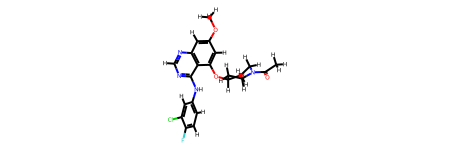

In [51]:
training_set[0]

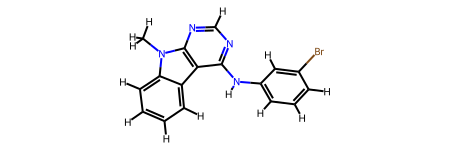

In [52]:
training_set[1]

In [60]:
(np.pi*(3*np.sqrt(2)/(2*np.pi))**(2/3))*1.08265**(-2)

np.float64(2.062899014367402)

In [61]:
(4*np.pi)/(3*2.7)

1.551403779550515

In [62]:
1.55/1.08265**2

1.3223777634466631

In [137]:
all((2.062*distances).tolist())

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

np.float64(0.0)

In [ ]:
default_radius = 1.08265 # default value used by PubChem3D
## see https://jcheminf.biomedcentral.com/articles/10.1186/1758-2946-3-13
default_sigma = (np.pi*(3*np.sqrt(2)/(2*np.pi))**(2/3))*default_radius**(-2)
np.sum(2*2.7*(np.pi/(ref_feats['sigma']+default_sigma))**(3/2)*np.exp(-default_sigma*ref_feats['sigma']))

In [49]:
def stratified_nn_pairs(query,ref):
    query_by_fam = query.groupby('Family',sort=False)
    ref_by_fam = ref.groupby('Family',sort=False)
    query_matched = []
    ref_matched = []
    results = []
    for f,group in query_by_fam:
        query_pos = group[['x','y','z']].to_numpy()
        if f in ref_by_fam.groups:
            ref_pos = ref_by_fam.get_group(f)[['x','y','z']].to_numpy()
            neigh = skl.neighbors.NearestNeighbors(n_neighbors=1)
            neigh.fit(ref_pos)
            dists, indices = neigh.kneighbors(query_pos,return_distance=True)
            indices = indices.ravel()
            results = results+dists.ravel().tolist()
            if len(query_matched)==0:
                query_matched = query_pos
            else:
                query_matched = np.concatenate((query_matched,query_pos))
            if len(ref_matched) == 0:
                ref_matched = ref_pos[indices,:]
            else:
                ref_matched = np.concatenate((ref_matched, ref_pos[indices,:]))
    return query_matched,ref_matched,results

In [97]:
test_mol = Chem.Mol(training_set[-4])
rdMolTransforms.CanonicalizeMol(test_mol)
test_query = extract_features([test_mol])
test_query

,Family,x,y,z
0,Donor,-1.264556,0.788507,-0.352915
1,Acceptor,2.937748,1.396536,0.171227
2,Acceptor,-0.809477,-1.542031,-0.627648
3,Acceptor,1.425688,-2.373279,-0.582542
4,Aromatic,2.408912,0.135209,-0.084257
5,Aromatic,0.544880,-1.318815,-0.483501
6,Aromatic,-4.073838,0.781160,-0.014607
7,Hydrophobe,3.242429,-0.931636,-0.197269
8,Hydrophobe,1.023766,-0.045046,-0.237266
9,Hydrophobe,-3.438322,1.823917,-0.670403


In [65]:
test_ref = test2.consensus_hits
test_ref

,Family,x,y,z,sigma,n_feats,Class,Matched,Match Partner,Maximum Similarity,Weight
0,Acceptor,-3.389769,-4.355955,3.186659,4.722193,8,active,False,NaN,1.074367e-03,8
1,Acceptor,3.194250,3.333249,0.004970,2.187098,41,active,False,NaN,1.398543e-01,41
2,Acceptor,1.931009,-0.763106,-0.251017,2.436521,19,active,False,NaN,1.146174e-01,19
3,Acceptor,-2.712648,2.078406,-0.076984,2.075971,39,active,True,24.0,9.281708e-01,1
4,Acceptor,-2.021593,-3.540975,-5.304187,2.808452,8,active,False,NaN,7.443736e-06,8
5,Acceptor,-4.180013,7.939939,-3.911911,4.279959,5,active,False,NaN,3.259080e-24,5
6,Acceptor,-1.521092,4.263366,0.078338,2.062902,40,active,True,6.0,8.873343e-01,1
7,Acceptor,6.188189,6.290083,-4.167850,2.984838,2,active,False,NaN,4.687012e-04,2
8,Acceptor,6.802099,4.554963,3.976749,2.992880,2,active,False,NaN,2.881013e-06,2
9,Aromatic,1.289671,3.178336,0.028501,2.104985,49,active,False,NaN,5.960538e-01,49


In [100]:
test_matches = test_ref.loc[test_ref['Matched']==True]
test_matches

,Family,x,y,z,sigma,n_feats,Class,Matched,Match Partner,Maximum Similarity,Weight
3,Acceptor,-2.712648,2.078406,-0.076984,2.075971,39,active,True,24.0,0.928171,1
6,Acceptor,-1.521092,4.263366,0.078338,2.062902,40,active,True,6.0,0.887334,1
11,Aromatic,-1.460401,2.720645,-0.100084,2.072936,47,active,True,38.0,0.890704,1
20,Donor,-1.558099,0.188267,-0.314437,2.063391,39,active,True,59.0,0.965911,1
21,Donor,3.389634,1.688103,0.091140,2.063082,18,active,True,75.0,0.814752,1


In [98]:
qm,rm,dists = stratified_nn_pairs(test_query,test_ref)

In [101]:
qm,rm,dists = stratified_nn_pairs(test_matches,test_query)
rm

array([[-0.80947681, -1.54203138, -0.62764758],
       [ 2.9377477 ,  1.396536  ,  0.17122709],
       [-4.0738379 ,  0.78115972, -0.01460669],
       [-1.26455554,  0.78850728, -0.35291456],
       [-1.26455554,  0.78850728, -0.35291456]])

In [102]:
qm

array([[-2.712648  ,  2.07840559, -0.0769842 ],
       [-1.52109189,  4.26336596,  0.07833815],
       [-1.46040116,  2.72064499, -0.10008354],
       [-1.55809925,  0.18826732, -0.31443664],
       [ 3.38963394,  1.68810319,  0.09114001]])

In [103]:
ssd,mat = rdAlignment.GetAlignmentTransform(qm,rm)
ssd

18.72024728157909

In [105]:
np.sqrt(ssd/5)

np.float64(1.9349546393432118)

In [104]:
mat

array([[-0.89238817,  0.45063236, -0.02395474, -0.68756149],
       [ 0.23318568,  0.50592377,  0.83046106,  1.01981671],
       [ 0.3863519 ,  0.73550773, -0.55656141,  0.08442301],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [106]:
new_points = np.ones((4,len(test_query)))
new_points[:3,:] = test_query[['x','y','z']].to_numpy().T
new_points

array([[-1.26455554,  2.9377477 , -0.80947681,  1.42568814,  2.40891246,
         0.54488032, -4.0738379 ,  3.24242866,  1.02376594, -3.43832184,
        -4.82540959, -5.46680011, -4.71333448, -3.32758865],
       [ 0.78850728,  1.396536  , -1.54203138, -2.37327862,  0.13520888,
        -1.31881508,  0.78115972, -0.93163612, -0.04504567,  1.82391678,
         1.85401203,  0.80833568, -0.25380235, -0.28477419],
       [-0.35291456,  0.17122709, -0.62764758, -0.58254184, -0.08425718,
        -0.48350071, -0.01460669, -0.19726908, -0.2372663 , -0.67040312,
        -0.49783794,  0.1602186 ,  0.65210412,  0.48107619],
       [ 1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ,  1.        ]])

In [107]:
transformed_points = np.dot(mat,new_points)
transformed_points

array([[ 0.80469379, -2.68395019, -0.64504805, -3.01535022, -2.77429862,
        -1.75652485,  3.30024902, -3.99616632, -1.61577349,  3.2187315 ,
         4.46598035,  4.55137049,  3.38856992,  2.14208675],
       [ 0.83078325,  2.5535956 , -0.47032891, -0.33220962,  1.57997367,
         0.07812658,  0.45293303,  1.14074348,  1.03871416,  0.58406846,
         0.41915403,  0.28704875,  0.33387703,  0.49931169],
       [ 0.3722314 ,  2.15129204, -1.01317146, -0.78610413,  1.16145238,
        -0.40596229, -0.90683346,  0.76170826,  0.57887875,  0.47064623,
        -0.13916558, -1.52231993, -2.28619228, -1.67839923],
       [ 1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ,  1.        ]])

In [108]:
new_pos = transformed_points[:3,:].T
new_pos

array([[ 0.80469379,  0.83078325,  0.3722314 ],
       [-2.68395019,  2.5535956 ,  2.15129204],
       [-0.64504805, -0.47032891, -1.01317146],
       [-3.01535022, -0.33220962, -0.78610413],
       [-2.77429862,  1.57997367,  1.16145238],
       [-1.75652485,  0.07812658, -0.40596229],
       [ 3.30024902,  0.45293303, -0.90683346],
       [-3.99616632,  1.14074348,  0.76170826],
       [-1.61577349,  1.03871416,  0.57887875],
       [ 3.2187315 ,  0.58406846,  0.47064623],
       [ 4.46598035,  0.41915403, -0.13916558],
       [ 4.55137049,  0.28704875, -1.52231993],
       [ 3.38856992,  0.33387703, -2.28619228],
       [ 2.14208675,  0.49931169, -1.67839923]])

In [109]:
test_query[['x','y','z']] = new_pos
test_query

,Family,x,y,z
0,Donor,0.804694,0.830783,0.372231
1,Acceptor,-2.683950,2.553596,2.151292
2,Acceptor,-0.645048,-0.470329,-1.013171
3,Acceptor,-3.015350,-0.332210,-0.786104
4,Aromatic,-2.774299,1.579974,1.161452
5,Aromatic,-1.756525,0.078127,-0.405962
6,Aromatic,3.300249,0.452933,-0.906833
7,Hydrophobe,-3.996166,1.140743,0.761708
8,Hydrophobe,-1.615773,1.038714,0.578879
9,Hydrophobe,3.218732,0.584068,0.470646


In [110]:
qm2,rm2,dists2 = stratified_nn_pairs(test_matches,test_query)
rm2

array([[-2.68395019,  2.5535956 ,  2.15129204],
       [-2.68395019,  2.5535956 ,  2.15129204],
       [-2.77429862,  1.57997367,  1.16145238],
       [ 0.80469379,  0.83078325,  0.3722314 ],
       [ 0.80469379,  0.83078325,  0.3722314 ]])

In [112]:
qm2

array([[-2.712648  ,  2.07840559, -0.0769842 ],
       [-1.52109189,  4.26336596,  0.07833815],
       [-1.46040116,  2.72064499, -0.10008354],
       [-1.55809925,  0.18826732, -0.31443664],
       [ 3.38963394,  1.68810319,  0.09114001]])

In [111]:
ssd,mat = rdAlignment.GetAlignmentTransform(qm2,rm2)
ssd

44.84944993037987

In [92]:
mat

array([[ 0.77531231,  0.43329588, -0.45950572, -0.98816018],
       [-0.2226547 ,  0.86835768,  0.44314763,  0.95038574],
       [ 0.59102936, -0.2412667 ,  0.76972376, -0.97787809],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [93]:
new_points = np.ones((4,len(test_query)))
new_points[:3,:] = test_query[['x','y','z']].to_numpy().T
transformed_points = np.dot(mat,new_points)
new_pos = transformed_points[:3,:].T
test_query[['x','y','z']] = new_pos
test_query

,Family,x,y,z
0,Donor,0.133550,-0.739720,-0.587481
1,Acceptor,4.069653,-0.650859,1.086728
2,Acceptor,0.423578,1.557477,-1.181413
3,Acceptor,2.416177,2.735377,-0.606027
4,Aromatic,3.494720,0.478817,0.512995
5,Aromatic,1.680049,1.571065,-0.610464
6,Aromatic,-2.172372,-1.423497,-2.078034
7,Hydrophobe,4.182746,1.650222,0.502571
8,Hydrophobe,2.206571,0.423762,-0.045733
9,Hydrophobe,-1.937165,-1.984772,-0.832666


In [94]:
qm2,rm2,dists2 = stratified_nn_pairs(test_query,test_ref)

In [95]:
rm2

array([[ 1.71255851e+00, -1.03384867e+00, -3.16258275e-01],
       [ 1.93100916e+00, -7.63105652e-01, -2.51017234e-01],
       [ 1.93100916e+00, -7.63105652e-01, -2.51017234e-01],
       [ 3.19424959e+00,  3.33324942e+00,  4.97038516e-03],
       [ 1.28967101e+00,  3.17833647e+00,  2.85014506e-02],
       [ 1.28967101e+00,  3.17833647e+00,  2.85014506e-02],
       [-1.07891637e+00, -1.97086057e+00, -2.59038207e+00],
       [ 5.11543252e+00, -1.69760977e-01, -2.19648026e-01],
       [ 1.40083927e+00,  3.27130044e+00,  8.24110570e-02],
       [-3.09374903e+00, -1.79513305e+00, -2.27441010e-01],
       [-3.09374903e+00, -1.79513305e+00, -2.27441010e-01],
       [-3.09374903e+00, -1.79513305e+00, -2.27441010e-01],
       [-3.09374903e+00, -1.79513305e+00, -2.27441010e-01],
       [-3.09374903e+00, -1.79513305e+00, -2.27441010e-01]])

In [96]:
ssd,mat = rdAlignment.GetAlignmentTransform(rm2[[0,1,3,4,5,6,8,9],:],qm2[[0,1,3,4,5,6,8,9],:])
ssd

28.46532702155332

In [87]:
dists

[0.669280564088893,
 1.960686967844175,
 2.8738195926771333,
 1.7198589681605025,
 3.24438614753199,
 2.7387639746316164,
 2.7577120736262413,
 2.0221518276727832,
 3.352988140616676,
 3.662303575017888,
 4.048212275946556,
 3.543966823679591,
 2.4025729918982037,
 1.6845953434733865]

In [88]:
qm2

array([[ 1.47672192e+00, -1.07577407e+00, -9.63900724e-01],
       [ 5.49815207e+00,  3.02955213e-01, -1.44450552e+00],
       [ 8.39071272e-01,  1.18797860e+00, -5.36336891e-01],
       [ 2.46176309e+00,  2.93538050e+00, -4.87075116e-01],
       [ 4.46177892e+00,  1.17322470e+00, -1.12132329e+00],
       [ 2.14765091e+00,  1.60645114e+00, -6.68197210e-01],
       [-1.03980192e+00, -2.30906268e+00, -1.35464439e+00],
       [ 4.72823407e+00,  2.49105748e+00, -9.26393471e-01],
       [ 3.14509512e+00,  7.02070720e-01, -9.83874919e-01],
       [ 3.57592966e-03, -2.99500187e+00, -7.52862044e-01],
       [-1.22386938e+00, -3.63364060e+00, -9.53400027e-01],
       [-2.27383120e+00, -2.94759287e+00, -1.55736852e+00],
       [-2.08335187e+00, -1.63115885e+00, -1.96787809e+00],
       [-8.57515896e-01, -9.92243030e-01, -1.76884527e+00]])